In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Minor Project
## Hate Speech detection
### Multichannel CNN

In [4]:
import numpy as np
import pandas as pd
import sklearn
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from itertools import chain
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/hate-speech-dataset-master.zip", 'r')
zip_ref.extractall()
zip_ref.close()
file_path="/content/hate-speech-dataset-master/all_files"

In [6]:
read_files=glob.glob(os.path.join(file_path,"*.txt"))
data=[]
file_name=[]
for files in read_files:
    with open(files,encoding='utf-8') as f:
        data.append(f.read())
        file_name.append(os.path.splitext(os.path.basename(files))[0])
data=pd.DataFrame(data,index=file_name)
data.head()

0
13595072_4  Þá var Persaflóastríðið og miklir umbrotatímar...
14111061_2  I 'm all alone and looking for companionship ,...
30412407_2  https : //www.youtube.com/watch ? v = DeiW _ b...
14078237_2             No wonder this races achieve nothing .
12861583_2            Officials are puzzled as to the cause .

In [7]:
Output=pd.read_csv("/content/hate-speech-dataset-master/annotations_metadata.csv",index_col=0)
Output=Output.drop(['user_id','subforum_id','num_contexts'],axis=1).sort_index()
Output.shape

(10944, 1)

In [16]:
dataSet=pd.merge(data,Output,how='outer',left_index=True,right_index=True)
dataSet=dataSet[(dataSet['label']=="noHate")|(dataSet['label']=='hate')]
dataSet.rename(columns={0:'Texts'},inplace=True)
dataSet['label']=(dataSet['label']=='hate').astype(int)
dataSet.head()

Texts  label
12834217_1   As of March 13th , 2014 , the booklet had been...      0
12834217_10  Thank you in advance. : ) Download the youtube...      0
12834217_2   In order to help increase the booklets downloa...      0
12834217_3   ( Simply copy and paste the following text int...      0
12834217_4   Click below for a FREE download of a colorfull...      1

In [0]:
import re
import string
def clean_text(text):
  text=text.lower()
  text=re.sub('\[.*?\]','',text)
  text=re.sub('[%s]'% re.escape(string.punctuation),'',text)
  text=re.sub('\w*\d\w*','',text)
  return text

In [19]:
dataSet['Texts']=dataSet.apply(lambda x:clean_text(x['Texts']),axis=1)
dataSet

Texts  label
12834217_1   as of march     the booklet had been downloade...      0
12834217_10  thank you in advance   download the youtube  d...      0
12834217_2   in order to help increase the booklets downloa...      0
12834217_3    simply copy and paste the following text into...      0
12834217_4   click below for a free download of a colorfull...      1
...                                                        ...    ...
33677015_1   apparently he came to the conclusion that his ...      0
33677019_1   wish we at least had a marine le pen to vote f...      0
33677019_2   its like the choices are white genocide candid...      0
33677053_1   why white people used to say that sex was a si...      1
33677053_2                                       now i get it       0

[10703 rows x 2 columns]

In [20]:
train_text,test_text,train_y,test_y=sklearn.model_selection.train_test_split(dataSet['Texts'],dataSet['label'],test_size=0.09)
print(train_text,'\n',train_y)
print(test_text,'\n',test_y)
print(test_y.shape,train_y.shape)

14300745_3     was nt bill clinton the first  black  president 
14674138_7     they follow the queen ant and would die for her 
31944563_1    its being reported by some of the british pres...
31777526_1    they are nt a band they are a group like a whi...
14066984_2                  we are all on the same bloddy side 
                                    ...                        
30564913_1    smh you all do nt understand hitler s message ...
31783690_1    take it slow then gradual  hell make them watc...
13595419_1                     welcome to stormfront  eldritch 
30611197_1    regarding the james murphy translation of mein...
13379474_2    any europeans traveling to this country must b...
Name: Texts, Length: 9739, dtype: object 
 14300745_3    0
14674138_7    0
31944563_1    0
31777526_1    0
14066984_2    0
             ..
30564913_1    0
31783690_1    1
13595419_1    0
30611197_1    0
13379474_2    0
Name: label, Length: 9739, dtype: int64
30608349_2       almost makes you wis

In [0]:
def create_tokens(lines):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  t_line=lines.apply(lambda x: nltk.word_tokenize(x))
  t_line=t_line.apply(lambda x: [w for w in x if not w in stop_words])
  return t_line

In [76]:
train_lines=create_tokens(train_text)
print(train_lines)
tokenizer= Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_lines)
tokenizer

14300745_3         [nt, bill, clinton, first, black, president]
14674138_7                     [follow, queen, ant, would, die]
31944563_1    [reported, british, press, usually, critical, ...
31777526_1    [nt, band, group, like, white, pride, group, p...
14066984_2                                       [bloddy, side]
                                    ...                        
30564913_1    [smh, nt, understand, hitler, message, people,...
31783690_1    [take, slow, gradual, hell, make, watch, mtv, ...
13595419_1                      [welcome, stormfront, eldritch]
30611197_1    [regarding, james, murphy, translation, mein, ...
13379474_2    [europeans, traveling, country, must, insane, ...
Name: Texts, Length: 9739, dtype: object


In [0]:
def encode_text(tokenizer, lines, length):
  encoded = tokenizer.texts_to_sequences(lines)
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

In [78]:
length=np.max(train_lines.apply(lambda x:len(x)))
length

146

In [0]:
train_x=encode_text(tokenizer,train_lines,length)
pd.DataFrame(train_x).to_csv("train_file.csv")

In [80]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

14281

In [81]:
import keras.engine.input_layer as ki
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
def define_model(length,vocab_size):
  # channel 1
  inputs1 = ki.Input(shape=(length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='tanh')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = ki.Input(shape=(length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='tanh')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = ki.Input(shape=(length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='tanh')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)
  # merge
  merged = concatenate([flat1, flat2, flat3])
  # interpretation
  dense1 = Dense(10, activation='tanh')(merged)
  ddense1 = Dropout(0.5)(dense1)
  outputs = Dense(1, activation='sigmoid')(ddense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize
  print(model.summary())
  return model
model=define_model(length,vocab_size)
model.fit([train_x,train_x,train_x],np.array(train_y),epochs=100,batch_size=128,validation_split=0.1)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 146)          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 146)          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 146)          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 146, 100)     1428100     input_22[0][0]                   
____________________________________________________________________________________________

In [63]:
test_lines=create_tokens(test_text)
test_x=encode_text(tokenizer,test_lines,length)
pd.DataFrame(test_x).to_csv("test_file.csv")
scores = model.evaluate([test_x,test_x,test_x], test_y, verbose=0)
print(scores)

[1.081833660747968, 0.8858921161825726]


In [0]:
yhat=model.predict([test_x,test_x,test_x],batch_size=100,verbose=1,use_multiprocessing=True)
yhat=(yhat>=0.5).astype(int)
tdf=pd.DataFrame(yhat).rename(columns={0:'Prediction'})
tdf.to_csv("op.csv")
tdf

964/964 [==============================] - 0s 29us/step


Prediction
0             0
1             0
2             0
3             0
4             0
..          ...
959           0
960           0
961           0
962           0
963           0

[964 rows x 1 columns]

In [0]:
i=113
print(test_text[i])
print(yhat[i])
print(test_y[i])

i m      pudgy with a gut and soft muscles  and i ve wrestled and overpowered bigger  ripped black guys and submitted them 
[0]
0


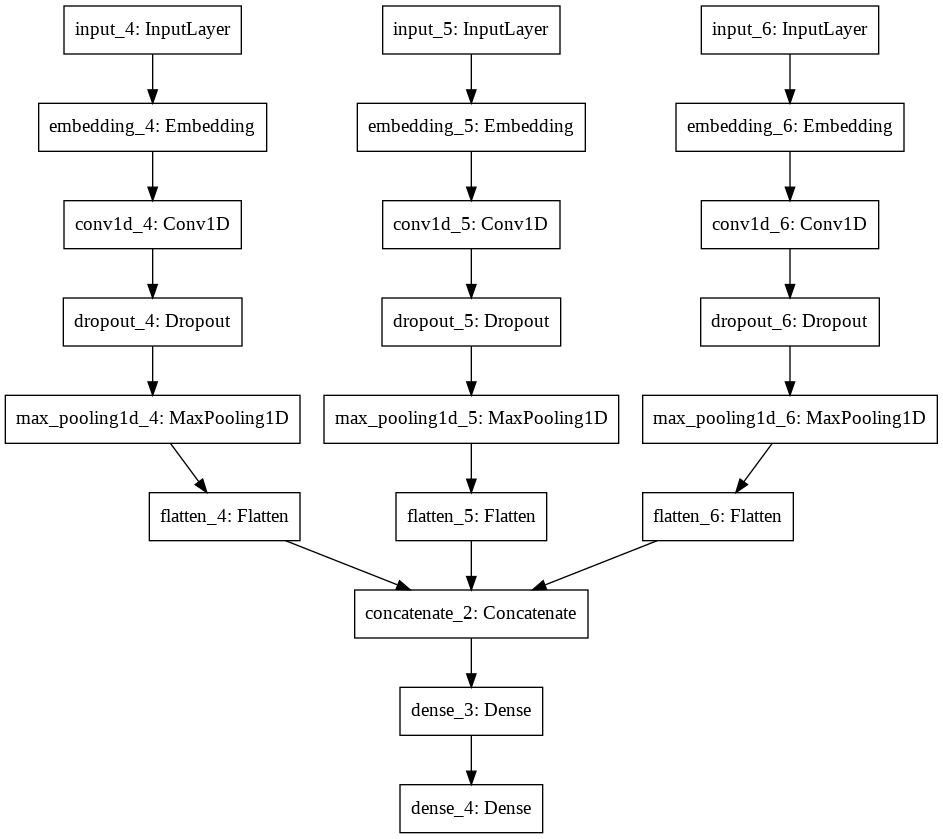

In [0]:
plot_model(model)

In [0]:
m=confusion_matrix(y_pred=yhat, y_true=test_y, labels=[1,0])
nm=confusion_matrix(y_pred=yhat, y_true=test_y, labels=[1,0],normalize='true')
print(m)
print(nm)

[[ 16  90]
 [ 24 834]]
[[0.1509434  0.8490566 ]
 [0.02797203 0.97202797]]


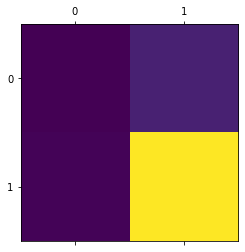

In [0]:
fig=plt.figure().add_subplot()
fig.matshow(m)

In [0]:
print(sklearn.metrics.classification_report(test_y, yhat, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       858
           1       0.40      0.15      0.22       106

    accuracy                           0.88       964
   macro avg       0.65      0.56      0.58       964
weighted avg       0.85      0.88      0.86       964

